# Pujol-like shear Calibration

In [3]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
import galsim

## Generate Galaxies

In [5]:
def generate_gal(i):
  #cat
  cat = galsim.COSMOSCatalog(sample="25.2")
  gal = cat.makeGalaxy(i, gal_type='parametric')
  gal_mag = cat.param_cat['mag_auto'][cat.orig_index[i]]  
  ##cfis photometry
  mag_zp = 32
  gal_flux = 10**(-(gal_mag-mag_zp)/2.5)
  gal = gal.withFlux(gal_flux)
  return gal

test:

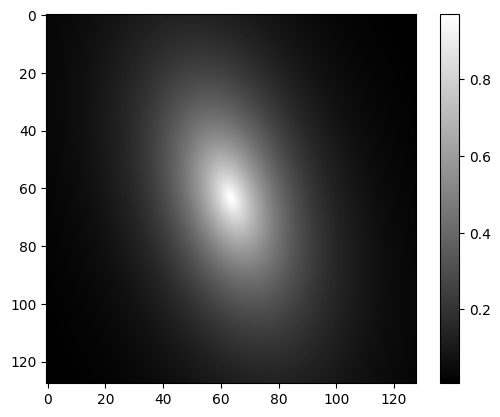

In [16]:
gal = generate_gal(2)
imshow(gal.drawImage(nx=128,ny=128,scale=0.01).array,cmap="gist_gray");colorbar()

## Make noise images

In [24]:
def noise_image(size=51,sky_level=400):
  rng = np.random.RandomState(1)
  noise=rng.normal(loc=sky_level,scale=np.sqrt(sky_level),size=[size,size])
  return noise 

In [25]:
nois = noise_image()

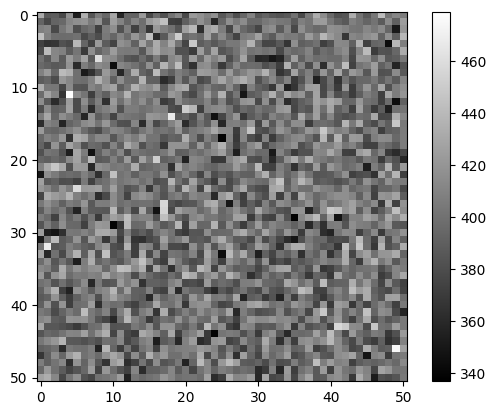

In [26]:
imshow(nois,cmap="gist_gray");colorbar()

## Transform array images into GalSim objects

In [32]:
def galsimator(im_array):
  image = galsim.Image(im_array,scale=0.1)
  galsim_img = galsim.InterpolatedImage(image,x_interpolant='lanczos14')
  return galsim_img  

In [33]:
galsimator(nois)

galsim.InterpolatedImage(galsim.Image(bounds=galsim.BoundsI(xmin=-25, xmax=25, ymin=-25, ymax=25), array=
array([[432.48690727, 387.76487173, 389.43656495, ..., 402.40317905,
        412.34406219, 406.0034064 ],
       [392.95500307, 377.14963604, 393.01314555, ..., 413.96064068,
        391.0574287 , 424.4901541 ],
       [408.06983284, 411.87157046, 378.10176309, ..., 393.79766453,
        351.30324472, 420.77649204],
       ...,
       [406.80709925, 390.70611062, 401.6686639 , ..., 403.19803487,
        395.54775181, 413.79185634],
       [395.04404988, 421.67903956, 399.73809177, ..., 420.07992807,
        402.07615362, 402.99375058],
       [426.72473436, 433.16344509, 412.25316973, ..., 378.79931478,
        384.44604763, 405.12104772]]), wcs=galsim.PixelScale(0.1)), galsim.Lanczos(14, True, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), galsim.Quintic(gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,

## Measure Ellipticities in Multiple Exposures

In [58]:
def model(flux,hlr,g1,g2,psfs,boxsize,scale):
  """
  Creates a model to fit on n exposures, 
  number of exposures is defined by how many psfs
  """
  model_image_list = []
  for psf in psfs:
    
    gal = galsim.Gaussian(flux=flux,
      half_light_radius = hlr
    ).shear(
      g1=g1,
      g2=g2
    )

    model = galsim.Convolve([gal,psf])

    model_array = model.drawImage(
      nx=boxsize,
      ny=boxsize,
      scale=scale
    ).array
    model_image_list += [model_array]
  
  #make n_image copies of the model to compare with each stamp
  
  return np.array(model_image_list)

def create_loss(model,images,psfs,boxsize,scale):
  """creates a loss function that depends only on fitable parameters"""
  return lambda hlr,g1,g2,flux :  sum((model(flux,hlr,g1,g2,psfs,boxsize,scale) - images)**2)

test:

In [67]:
gal = generate_gal(2)
psf1 = galsim.Kolmogorov(fwhm=.7)
psf2 = galsim.Kolmogorov(fwhm=.6)
obs1 = galsim.Convolve([gal,psf1]) + galsimator(nois)
obs2 = galsim.Convolve([gal,psf1]) + galsimator(nois.T)

In [61]:
psfs = [psf1,psf2]


In [62]:
model(flux=10,hlr=.5,g1=.1,g2=0,psfs=psfs,boxsize=51,scale=.1)

array([[[1.6581658e-05, 1.7886450e-05, 1.9302408e-05, ...,
         1.9302408e-05, 1.7886450e-05, 1.6581658e-05],
        [1.7941649e-05, 1.9432078e-05, 2.1059381e-05, ...,
         2.1059381e-05, 1.9432078e-05, 1.7941649e-05],
        [1.9431007e-05, 2.1135496e-05, 2.3008684e-05, ...,
         2.3008684e-05, 2.1135496e-05, 1.9431007e-05],
        ...,
        [1.9431007e-05, 2.1135496e-05, 2.3008684e-05, ...,
         2.3008684e-05, 2.1135496e-05, 1.9431007e-05],
        [1.7941649e-05, 1.9432078e-05, 2.1059381e-05, ...,
         2.1059381e-05, 1.9432078e-05, 1.7941649e-05],
        [1.6581658e-05, 1.7886450e-05, 1.9302408e-05, ...,
         1.9302408e-05, 1.7886450e-05, 1.6581658e-05]]], dtype=float32)

In [65]:
loss=create_loss(model=model,images=obs_img,psfs=psfs,boxsize=51,scale=.1)

In [66]:
loss(1,.5,0,0)

4496552.122799603

## Create a basic metacal implementation

In [6]:
def get_metacal_type(deconv_gal,step,type_name):
  if type_name == "noshear":
    return deconv_gal.shear(0,0)
  elif type_name == "1p":
    return deconv_gal.shear(step,0) 
  elif type_name == "2p":
    return deconv_gal.shear(0,step)
  elif type_name == "1m":
    return deconv_gal.shear(-step,0)
  elif type_name == "2m":
    return deconv_gal.shear(0,-step)
  
def get_fixnoise(noise_image,step,type_name):
  sheared_noise = get_metacal_type(noise_image,step,type_name)
  rotated_sheared_noise = sheared_noise.
  return rotated_sheared_noise

def get_all_metacal(
  gal,
  psf,
  reconv_psf,
  noise_image=None,
  types=['noshear','1p','1m','2p','2m'],
  step=0.01
):
  
  inv_psf = galsim.Deconvolve(psf)
  deconv_gal = galsim.Convolve([gal,inv_psf])
  obsdict = {}
  for t in types:
    sheared_gal = get_metacal_type(deconv_gal,step,type_name=t)
    reconv_galaxy = galsim.Convolve([sheared_gal,reconv_psf])
    obsdict +={t: }#TODO
  
  if fixnoise== True:
  for t in types:
    sheared_gal = get_metacal_type(deconv_gal,step,type_name=t)
    reconv_galaxy = galsim.Convolve([sheared_gal,reconv_psf])
    obsdict +={t: }
    
  return obsdict 

SyntaxError: invalid syntax (162084492.py, line 15)

## Pujol Test

In [7]:
def pujol_sims(gal_model,psf_model,step=0.02):
  gal1p = gal.shear(step,0)
  gal2p = gal.shear(0,step)
  
  #noshear
  obsns = galsim.Convolve([gal,psf_model])
  #1p
  obs1p = galsim.Convolve([gal1p,psf_model])
  #2p
  obs2p = galsim.Convolve([gal2p,psf_model])
    
  pujobsdict = {
    'noshear':obsns,
    '1p':obs1p,
    '2p':obs2p,  
  }  
  return  pujobsdict

In [8]:
def apply_noise(pujobsdict,noise):
  for key in pujobsdict.keys():
    pujobsdict[key] += noise
  return pujobsdict

In [9]:
def measure_ellipticities(obsdict,method):
  resdict = {}
  for key in obsdict.keys():
    resdict += {key: method(pujobsdict[key])}
  return resdict

In [10]:
def get_metacal_response(resdict,shear_type = 'g'):
  '''gets the shear response for ngmix-like results'''

  #noshear
  g0s = np.array(resdict['noshear'][shear_type])
  
  #shear
  g1p = np.array(resdict['1p'][shear_type])
  g1m = np.array(resdict['1m'][shear_type])
  g2p = np.array(resdict['2p'][shear_type])
  g2m = np.array(resdict['2m'][shear_type])    
  
  R11 = (g1p[0]-g1m[0])/(2*step)
  R21 = (g1p[1]-g1m[1])/(2*step) 
  R12 = (g2p[0]-g2m[0])/(2*step)
  R22 = (g2p[1]-g2m[1])/(2*step)
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])

  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,  
  } 
      
  return ellip_dict, R

def get_pujol_response(resdict):

  #noshear
  g0s = np.array(resdict['noshear'])
  
  #shear
  g1p = np.array(resdict['1p'])
  g2p = np.array(resdict['2p'])   
  
  R11 = (g1p[0]-g0s[0])/(2*step)
  R21 = (g1p[1]-g0s[1])/(2*step) 
  R12 = (g2p[0]-g0s[0])/(2*step)
  R22 = (g2p[1]-g0s[1])/(2*step)
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])

  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,  
  } 
      
  return ellip_dict, R